In [14]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc


pd.set_option("display.max_columns", None)

import argparse

In [15]:
train_data = data_utils.load_anndata(
    mode='train',
    normalize=True,
    remove_batch_effect=False,
    preload_subsample_frac=None
)

d:\dlls-hack\.venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
train_data

View of AnnData object with n_obs × n_vars = 66175 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'log1p'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [17]:
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
    torch.tensor(train_data.X.toarray()).float(), batch_size=128, shuffle=True
)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, hidden_dims),
                                     nn.BatchNorm1d(hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                     nn.BatchNorm1d(hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     )  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(hidden_dims, latent_dims))

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        z = mu 
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(nn.Linear(latent_dims, hidden_dims),
                                    nn.BatchNorm1d(hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, hidden_dims),
                                    nn.BatchNorm1d(hidden_dims),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(hidden_dims, input_dims),
                                     
                                     )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded


class AE(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout, z_dropout):
        super(AE, self).__init__()
        self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

def train(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()
            x = data.to(device)
            x_hat, z = model(x)
            loss = F.mse_loss(x_hat, x)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {sum_loss/len(dataloader)}")

class AE_Lightning(pl.LightningModule):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout, z_dropout):
        super(AE_Lightning, self).__init__()
        self.model = AE(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
        self.latent_dims = latent_dims
        self.hidden_dims = hidden_dims
        self.input_dims = input_dims
        self.dropout = dropout
        self.z_dropout = z_dropout

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x = batch
        x_hat, z = self.model(x)
        loss = F.mse_loss(x_hat, x)
        self.log("Train loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [20]:
latent_dims = 10
hidden_dims = 128
input_dims = train_data.shape[1]
dropout = 0.2
z_dropout = 0.2
epochs = 2

ae = AE(latent_dims, hidden_dims, input_dims, dropout, z_dropout).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

ae_lightning = AE_Lightning(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
trainer = pl.Trainer(max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
train(ae, train_loader, optimizer, epochs)

Epoch 1, Loss: 0.08302881627756115
Epoch 2, Loss: 0.0670985062417486


In [22]:
trainer.fit(
    model=ae_lightning,
    train_dataloaders=train_loader
    )


  | Name  | Type | Params
-------------------------------
0 | model | AE   | 3.7 M 
-------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.695    Total estimated model params size (MB)
d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 517/517 [00:38<00:00, 13.55it/s, v_num=5, Train loss_step=0.0634, Train loss_epoch=0.0671]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 517/517 [00:38<00:00, 13.48it/s, v_num=5, Train loss_step=0.0634, Train loss_epoch=0.0671]


In [25]:
train_data_tensor = torch.tensor(train_data.X.toarray()).float()
latent_embeddings = ae.encoder(train_data_tensor).detach().numpy()
latent_embeddings_lightning = ae_lightning.model.encoder(train_data_tensor).detach().numpy()

In [26]:
train_data.obsm["latent_embeddings"] = latent_embeddings
train_data.obsm["latent_embeddings_lightning"] = latent_embeddings_lightning

C:\Users\przem\AppData\Local\Temp\ipykernel_3652\2997097216.py:1: ImplicitModificationWarning: Setting element `.obsm['latent_embeddings']` of view, initializing view as actual.
  train_data.obsm["latent_embeddings"] = latent_embeddings
d:\dlls-hack\.venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


d:\dlls-hack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


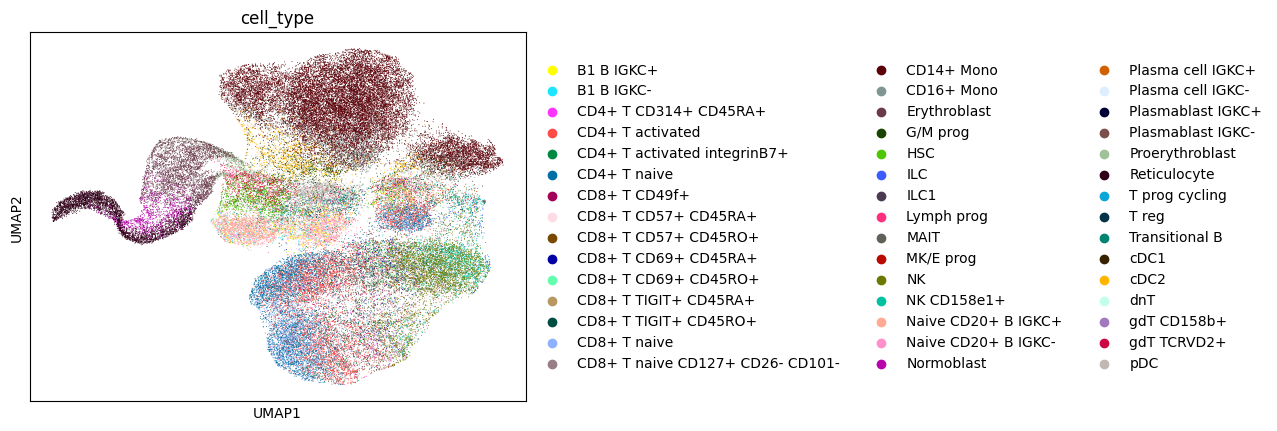

In [27]:
sc.pp.neighbors(train_data, n_neighbors=10, use_rep='latent_embeddings')
sc.tl.umap(train_data)
sc.pl.umap(train_data, color='cell_type')

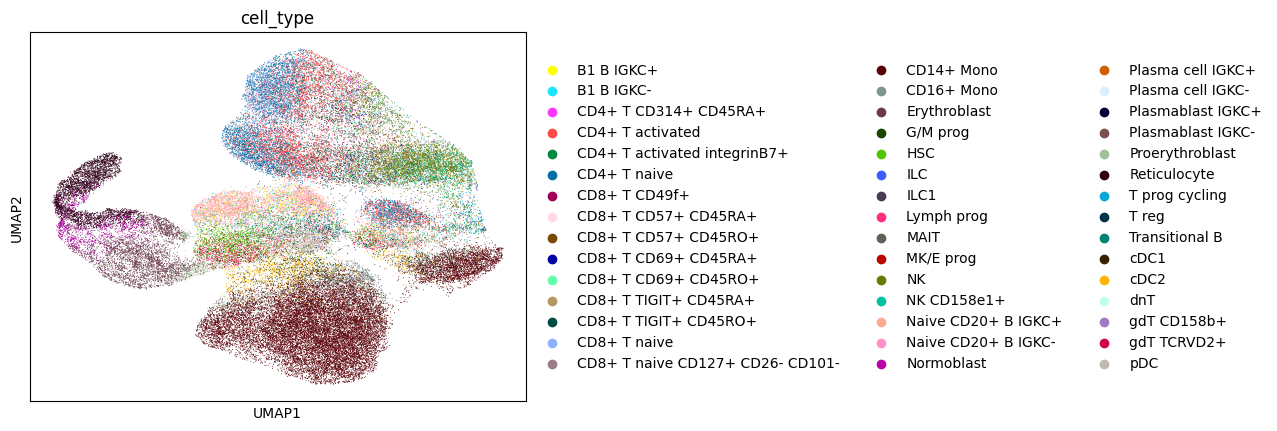

In [28]:
sc.pp.neighbors(train_data, n_neighbors=10, use_rep='latent_embeddings_lightning')
sc.tl.umap(train_data)
sc.pl.umap(train_data, color='cell_type')